In [24]:
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.optimize import minimize


### ステップ1: データ生成（制約条件を満たすデータを生成）

In [6]:
def generate_data(num_samples=1000):
    x1 = np.random.uniform(0.01,0.3,num_samples)
    x2 = np.random.uniform(0.01,0.3,num_samples)
    x3 = (0.3-x1-0.5*x2)/0.2
    #x3が0より大きいものだけを残す
    mask = (x3>0)
    x1,x2,x3 = x1[mask],x2[mask],x3[mask]
    # 目的関数Qを計算
    Q = 1/x1 + 1.5/x2 + 2.0/x3
    return np.stack([x1,x2,x3],axis=1),Q



In [25]:
X,y = generate_data()
X_tensor = torch.tensor(X,dtype=torch.float32)
y_tensor = torch.tensor(y,dtype=torch.float32).unsqueeze(1)

In [26]:
X_tensor

tensor([[0.1504, 0.2223, 0.1921],
        [0.1663, 0.0365, 0.5771],
        [0.1506, 0.0635, 0.5883],
        ...,
        [0.1516, 0.1065, 0.4758],
        [0.0893, 0.1560, 0.6637],
        [0.1093, 0.1428, 0.5966]])

In [27]:
y_tensor

tensor([[  23.8060],
        [  50.5309],
        [  33.6497],
        [  24.4264],
        [  32.3864],
        [  71.0807],
        [  24.5884],
        [  49.5302],
        [ 130.0660],
        [  22.9155],
        [  55.9913],
        [  28.4153],
        [  48.6344],
        [  97.7756],
        [  40.2812],
        [  20.9832],
        [  67.4363],
        [  27.2115],
        [  27.4461],
        [  67.6972],
        [  26.9976],
        [  20.8119],
        [  34.1896],
        [  33.2114],
        [  24.0347],
        [  87.1022],
        [  22.2029],
        [  96.6157],
        [  28.9950],
        [  25.3522],
        [  66.7502],
        [  39.3105],
        [  43.3951],
        [  23.2982],
        [  27.1698],
        [  21.4865],
        [  21.2133],
        [  26.5767],
        [  21.1138],
        [  21.9067],
        [  27.7566],
        [  71.0796],
        [  26.8995],
        [  38.5347],
        [  34.2863],
        [  25.4295],
        [  29.8308],
        [  33

In [28]:
class SurrogateModel(nn.Module):
    def __init__(self):
        super(SurrogateModel,self).__init__()
        self.model = nn.Sequential(
            nn.Linear(3,64),
            nn.ReLU(),
            nn.Linear(64,64),
            nn.ReLU(),
            nn.Linear(64,1)
        )
    def forward(self,x):
        return self.model(x)

In [29]:
model = SurrogateModel()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(),lr=0.01)

In [30]:
epochs = 10000
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    predictions = model(X_tensor)
    loss = criterion(predictions,y_tensor)
    loss.backward()
    optimizer.step()
    if epoch %10 ==0:
        print(f'Epoch:{epoch}, Loss:{loss.item()}')

Epoch:0, Loss:34364.0390625
Epoch:10, Loss:33508.8125
Epoch:20, Loss:31650.568359375
Epoch:30, Loss:31512.294921875
Epoch:40, Loss:31186.10546875
Epoch:50, Loss:30905.224609375
Epoch:60, Loss:30658.2734375
Epoch:70, Loss:30391.474609375
Epoch:80, Loss:30104.74609375
Epoch:90, Loss:29797.76171875
Epoch:100, Loss:29436.31640625
Epoch:110, Loss:29028.578125
Epoch:120, Loss:28635.9765625
Epoch:130, Loss:28283.83203125
Epoch:140, Loss:27979.318359375
Epoch:150, Loss:27700.392578125
Epoch:160, Loss:27415.912109375
Epoch:170, Loss:27129.828125
Epoch:180, Loss:26844.6875


Epoch:190, Loss:26556.09765625
Epoch:200, Loss:26255.25390625
Epoch:210, Loss:25943.822265625
Epoch:220, Loss:25633.18359375
Epoch:230, Loss:25321.216796875
Epoch:240, Loss:25003.935546875
Epoch:250, Loss:24681.376953125
Epoch:260, Loss:24346.931640625
Epoch:270, Loss:23996.34765625
Epoch:280, Loss:23643.859375
Epoch:290, Loss:23284.509765625
Epoch:300, Loss:22908.46484375
Epoch:310, Loss:22512.130859375
Epoch:320, Loss:22103.375
Epoch:330, Loss:21686.412109375
Epoch:340, Loss:21251.083984375
Epoch:350, Loss:20808.326171875
Epoch:360, Loss:20371.8671875
Epoch:370, Loss:19922.716796875
Epoch:380, Loss:19469.390625
Epoch:390, Loss:19007.177734375
Epoch:400, Loss:18524.521484375
Epoch:410, Loss:18040.65234375
Epoch:420, Loss:17561.83203125
Epoch:430, Loss:17099.33203125
Epoch:440, Loss:16637.634765625
Epoch:450, Loss:16195.3896484375
Epoch:460, Loss:15767.048828125
Epoch:470, Loss:15348.5703125
Epoch:480, Loss:14933.85546875
Epoch:490, Loss:14562.302734375
Epoch:500, Loss:14177.5107421875

In [31]:
# ステップ3: 学習済みANNを用いた最適化
def surrogate_Q(x):
    x_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(0)
    with torch.no_grad():
        return model(x_tensor).item()

In [32]:
def constraint(x):
    return x[0]+0.5*x[1]+0.2*x[2]-0.3 

In [33]:
x0 = [0.1,0.1,0.1]
bounds = ((0.01,0.3),(0.01,0.3),(0.01,0.3))

constraints = {"type":"eq","fun":constraint}

result = minimize(surrogate_Q,x0,method="SLSQP",bounds=bounds,constraints=constraints)
x_opt = result.x
Qmin = surrogate_Q(x_opt)

print("最適な厚さ:")
print(f"x1 = {x_opt[0]:.4f}, x2 = {x_opt[1]:.4f}, x3 = {x_opt[2]:.4f}")
print(f"最小のQ = {Qmin:.4f}")

最適な厚さ:
x1 = 0.1190, x2 = 0.3000, x3 = 0.1552
最小のQ = 26.3753


/workspaces/design_and_optimization/.venv/lib/python3.12/site-packages/scipy/optimize/_slsqp_py.py:434: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


# Lecture

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Heat loss
def heat_loss(x1, x2, x3):
    Q = 1 / x1 + 1.5 / x2  + 2.0 / x3
    return Q

In [18]:
# Generate training dataset
n_row = 50
n_col = 50
n_samples = n_row * n_col

x1 = torch.zeros(n_samples, 1)
x2 = torch.zeros(n_samples, 1)
x3 = torch.zeros(n_samples, 1)

x1_min, x1_max = 0.05, 0.25

for i in range(n_samples):
    row = int(i / n_col)
    col = i - row * n_col
    x1[i] = row * (x1_max - x1_min) / n_row + x1_min
    
    x2_min = 0.05
    x2_max = 0.6 - 2 * x1[i] - 0.05
    x2[i] =  col * (x2_max - x2_min) / n_col + x2_min
    
    x3[i] = 1.5 - 5 * x1[i] - 2.5 * x2[i]

x3_min = min(x3)
x3_max = max(x3)

# Normalize inputs and outputs
def normalize(data, data_min, data_max):
    return (data - data_min) / (data_max - data_min)

def denormalize(data, data_min, data_max):
    return data * (data_max - data_min) + data_min

# Normalize data
x1_norm = normalize(x1, x1_min, x1_max)
x2_norm = normalize(x2, x2_min, x2_max)
x3_norm = normalize(x3, x3_min, x3_max)
Q = heat_loss(x1, x2, x3)
Q_min, Q_max = Q.min(), Q.max()  # Save for denormalization
Q_norm = normalize(Q, Q_min, Q_max)

# Combine normalized inputs into a single tensor
inputs_norm = torch.cat((x1_norm, x2_norm), dim=1)
outputs_norm = Q_norm.view(-1, 1)

In [19]:
# Define a neural network model
class SurrogateModel(nn.Module):
    def __init__(self):
        super(SurrogateModel, self).__init__()
        self.fc1 = nn.Linear(2, 20)
        self.fc2 = nn.Linear(20, 20)
        self.fc3 = nn.Linear(20, 1)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [20]:
# Initialize the model, loss function, and optimizer
model = SurrogateModel()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.002)

# Train the model
n_epochs = 10000
loss_history = []

for epoch in range(n_epochs):
    model.train()
    optimizer.zero_grad()
    
    # Forward pass
    predictions = model(inputs_norm)
    loss = criterion(predictions, outputs_norm)
    loss.backward()
    optimizer.step()
    
    loss_history.append(loss.item())
    if (epoch + 1) % 200 == 0:
        print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {loss.item():.5f}')

Epoch [200/10000], Loss: 0.00424
Epoch [400/10000], Loss: 0.00202
Epoch [600/10000], Loss: 0.00140
Epoch [800/10000], Loss: 0.00098
Epoch [1000/10000], Loss: 0.00075
Epoch [1200/10000], Loss: 0.00047
Epoch [1400/10000], Loss: 0.00069
Epoch [1600/10000], Loss: 0.00089
Epoch [1800/10000], Loss: 0.00048
Epoch [2000/10000], Loss: 0.00024
Epoch [2200/10000], Loss: 0.00036
Epoch [2400/10000], Loss: 0.00066
Epoch [2600/10000], Loss: 0.00019
Epoch [2800/10000], Loss: 0.00036
Epoch [3000/10000], Loss: 0.00016
Epoch [3200/10000], Loss: 0.00017
Epoch [3400/10000], Loss: 0.00017
Epoch [3600/10000], Loss: 0.00039
Epoch [3800/10000], Loss: 0.00129
Epoch [4000/10000], Loss: 0.00043
Epoch [4200/10000], Loss: 0.00020
Epoch [4400/10000], Loss: 0.00052
Epoch [4600/10000], Loss: 0.00031
Epoch [4800/10000], Loss: 0.00045
Epoch [5000/10000], Loss: 0.00071
Epoch [5200/10000], Loss: 0.00022
Epoch [5400/10000], Loss: 0.00015
Epoch [5600/10000], Loss: 0.00034
Epoch [5800/10000], Loss: 0.00025
Epoch [6000/10000]

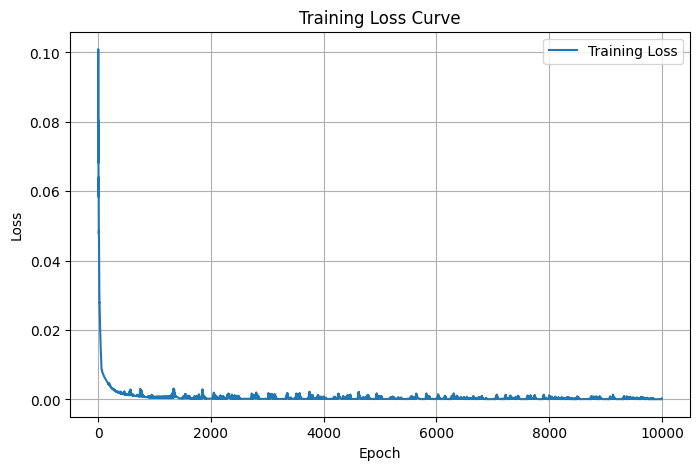

In [21]:
# Plot the training loss
plt.figure(figsize=(8, 5))
plt.plot(loss_history, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.grid(True)
plt.show()

In [22]:
# Initial guess for optimization
x_opt = torch.tensor([0.5, 0.5], requires_grad=True)

# Optimizer for the optimization process
optimizer = optim.Adam([x_opt], lr=0.2)

# Optimization loop
n_iterations = 4000
for iteration in range(n_iterations):
    optimizer.zero_grad()
    
    # Predict normalized Q
    Q_pred_norm = model(x_opt)
    Q_pred = denormalize(Q_pred_norm, Q_min, Q_max)  # Denormalize for penalty calculation
    
    # Denormalize inputs
    x1_denorm = denormalize(x_opt[0], x1_min, x1_max)
    x2_denorm = denormalize(x_opt[1], x2_min, x2_max)
    
    # Loss for minimization
    loss = Q_pred
    loss.backward()
    optimizer.step()
    
    if (iteration + 1) % 500 == 0:
        print(f'Iteration [{iteration + 1}/{n_iterations}], Predicted Q: {Q_pred.item():.4f}, x_opt: {x_opt.data.numpy()}')

# Final optimized values (denormalized)
x1_opt = denormalize(x_opt[0].detach(), x1_min, x1_max)
x2_opt = denormalize(x_opt[1].detach(), x2_min, x2_max)

print(f'x1= {x1_opt.item():.2f}')
print(f'x2= {x2_opt.item():.2f}')
print(f'x3= {1.5 - 5 * x1_opt.item() - 2.5 * x2_opt.item():.2f}')

Iteration [500/4000], Predicted Q: 21.8738, x_opt: [ 0.48596257 17.654785  ]
Iteration [1000/4000], Predicted Q: 21.6867, x_opt: [ 0.32527733 22.916355  ]
Iteration [1500/4000], Predicted Q: 21.7183, x_opt: [ 0.25451717 20.802822  ]
Iteration [2000/4000], Predicted Q: 21.6885, x_opt: [ 0.32438302 22.894182  ]
Iteration [2500/4000], Predicted Q: 21.7183, x_opt: [ 0.2309808 20.807974 ]
Iteration [3000/4000], Predicted Q: 21.9659, x_opt: [ 0.30779657 23.399607  ]
Iteration [3500/4000], Predicted Q: 21.7068, x_opt: [ 0.27418762 21.61095   ]
Iteration [4000/4000], Predicted Q: 21.6975, x_opt: [ 0.2951867 23.011215 ]
x1= 0.11
x2= 0.23
x3= 0.37


In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from scipy.optimize import minimize

# ステップ1: データ生成（制約条件を満たすデータを生成）
def generate_data(num_samples=1000):
    x1 = np.random.uniform(0.01, 0.3, num_samples)
    x2 = np.random.uniform(0.01, 0.3, num_samples)
    x3 = (0.3 - x1 - 0.5 * x2) / 0.2  # 制約条件からx3を計算
    mask = (x3 > 0)  # x3が正になる条件をフィルタ
    x1, x2, x3 = x1[mask], x2[mask], x3[mask]
    Q = 1 / x1 + 1.5 / x2 + 2.0 / x3  # 目的関数Qを計算
    return np.stack([x1, x2, x3], axis=1), Q

# 訓練データを生成
X, y = generate_data()
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

# ステップ2: PyTorchでANNを構築
class SurrogateModel(nn.Module):
    def __init__(self):
        super(SurrogateModel, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(3, 64),  # 入力層
            nn.ReLU(),         # 活性化関数
            nn.Linear(64, 64), # 隠れ層
            nn.ReLU(),
            nn.Linear(64, 1)   # 出力層
        )
    
    def forward(self, x):
        return self.model(x)

# モデルの初期化
model = SurrogateModel()
criterion = nn.MSELoss()  # 損失関数
optimizer = optim.Adam(model.parameters(), lr=0.01)  # オプティマイザ

# ANNの訓練
epochs = 10000
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    predictions = model(X_tensor)
    loss = criterion(predictions, y_tensor)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

# ステップ3: 学習済みANNを用いた最適化
def surrogate_Q(x):
    x_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(0)
    with torch.no_grad():
        return model(x_tensor).item()

# 制約条件
def constraint(x):
    return x[0] + 0.5 * x[1] + 0.2 * x[2] - 0.3

# 初期値
x0 = [0.1, 0.1, 0.1]

# 各変数の範囲（正の厚さを保証）
bounds = [(0.01, 0.3), (0.01, 0.3), (0.01, 0.3)]

# Scipyで使用する制約条件の形式
constraints = {'type': 'eq', 'fun': constraint}

# 最適化
result = minimize(surrogate_Q, x0, method='SLSQP', bounds=bounds, constraints=constraints)

# 結果を出力
x_opt = result.x
Q_min = surrogate_Q(x_opt)

print("最適な厚さ:")
print(f"x1 = {x_opt[0]:.4f}, x2 = {x_opt[1]:.4f}, x3 = {x_opt[2]:.4f}")
print(f"最小のQ = {Q_min:.4f}")


Epoch 0, Loss: 9470.8223
Epoch 10, Loss: 9121.0088
Epoch 20, Loss: 8047.0190
Epoch 30, Loss: 7007.5640
Epoch 40, Loss: 7042.8389
Epoch 50, Loss: 6986.5073
Epoch 60, Loss: 6921.1899
Epoch 70, Loss: 6895.4648
Epoch 80, Loss: 6859.3076
Epoch 90, Loss: 6821.2925
Epoch 100, Loss: 6779.8525
Epoch 110, Loss: 6734.8730
Epoch 120, Loss: 6685.6504
Epoch 130, Loss: 6628.4829
Epoch 140, Loss: 6562.1328
Epoch 150, Loss: 6485.0640
Epoch 160, Loss: 6403.0537
Epoch 170, Loss: 6309.8174
Epoch 180, Loss: 6206.6157
Epoch 190, Loss: 6099.9028
Epoch 200, Loss: 5988.9609
Epoch 210, Loss: 5883.3789
Epoch 220, Loss: 5784.3037
Epoch 230, Loss: 5680.7783
Epoch 240, Loss: 5580.6660
Epoch 250, Loss: 5478.4478
Epoch 260, Loss: 5373.9517
Epoch 270, Loss: 5276.2158
Epoch 280, Loss: 5180.9150
Epoch 290, Loss: 5086.7495
Epoch 300, Loss: 4993.7446
Epoch 310, Loss: 4898.2788
Epoch 320, Loss: 4798.1128
Epoch 330, Loss: 4694.7788
Epoch 340, Loss: 4586.2681
Epoch 350, Loss: 4476.8994
Epoch 360, Loss: 4369.0596
Epoch 370, L